# Diagnostics: mean bias and plotting of difference maps

A notebook to demonstrate the usage of an implemented plotting function in Valenspy

In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from pathlib import Path

from dask.diagnostics import ProgressBar
from valenspy.preprocessing_tasks.regrid import remap_cdo
import warnings
import xarray as xr

# Turn off all warnings
warnings.filterwarnings('ignore')


# define machine name - used for paths of (observational) datasets
machine = 'hortense'



## 0. Settings

In [2]:
model = 'CCLM'
ref_dataset = 'ERA5'
variable = 'tas'

## 1. Loading data

### 1.1 Model data

To be replaced with automatic input manager returning the ds

In [3]:
# get lookup file for model
mod_LOOKUP = load_yml(model+"_lookup")
mod_var = mod_LOOKUP[variable]['mod_name']

experiment = "EUR11_CO_TA_GC_TSO"
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

# define the path
directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

# define the CCLM files for the corresponding variable
mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory
    
ds_mod_raw = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

# renaming to be able to compare
ds_mod_raw = ds_mod_raw.rename({mod_var:variable})
ds_mod_raw.attrs['dataset'] = model
ds_mod_raw[variable].attrs['dataset'] = model

### 1.2. Load reference data

here we will use ERA5

In [4]:
manager = vp.InputManager(machine=machine)

ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region="europe")


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']


## 2. Preprocessing: remapping, resampling and time selection
in this example, this means selecting time and remapping

In [5]:
# regrid
# retrieve ERA5 gridfile - for regridding 
gridfile = manager._get_file_paths(ref_dataset,variable, period=[1995,1995],freq="hourly",region="europe")[0]
ds_mod = remap_cdo(gridfile, ds_mod_raw, remap_method = "con")

# resample ERA5 hourly data to daily
ds_obs = ds_obs.resample(time='1D').mean()    

# for both datasets, select summer months (JJA)
ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))
ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))


In [24]:
def plot_map(da: xr.DataArray, ax=None, title=None,cbar_label=None, **kwargs):
    
    """
    Plots a simple map of a 2D xarray DataArray.

    This function creates a map plot for a given 2D xarray DataArray, optionally using 
    a provided matplotlib Axes, which needs to have a projection. It automatically sets the colorbar label based on the 
    DataArray's attributes and adds features like coastlines and country borders.

    Parameters:
    -----------
    da : xr.DataArray
        The 2D xarray DataArray to plot. It should have latitude and longitude dimensions.
    ax : matplotlib.axes.Axes, optional
        The matplotlib Axes on which to plot the map. If not provided, a new Axes with a 
        PlateCarree projection will be created.
    title : str, optional
        The title for the plot. If not provided, a default title based on the DataArray's 
        long_name attribute will be set.
    **kwargs : 
        Additional keyword arguments to pass to the xarray DataArray plot method.

    Returns:
    --------
    ax : matplotlib.axes.Axes
        The matplotlib Axes with the plot.

    Example:
    --------
    >>> import xarray as xr
    >>> import matplotlib.pyplot as plt
    >>> import cartopy.crs as ccrs
    >>> fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    >>> ax = plot_map(da, ax=ax)
    """
    
    # If ax is not provided, create a new one
    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set colorbar label
    if cbar_label is None: 
        cbar_label =  f"{da.attrs.get('long_name', 'Data')} ({da.attrs.get('units', '')})"

    if title is None: 
        title = f"{da.attrs.get('long_name', 'Data')} ({da.name})"

    cbar_kwargs = {'label':cbar_label}

    # Plot the data array with the specified colorbar axis
    da.plot(ax=ax, cbar_kwargs=cbar_kwargs, **kwargs)

    # Set the title
    ax.set_title(title)

    # Add coastline and country borders
    _add_features(ax)

    return ax

<GeoAxes: title={'center': 'Mean bias of Near-Surface Air Temperature'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

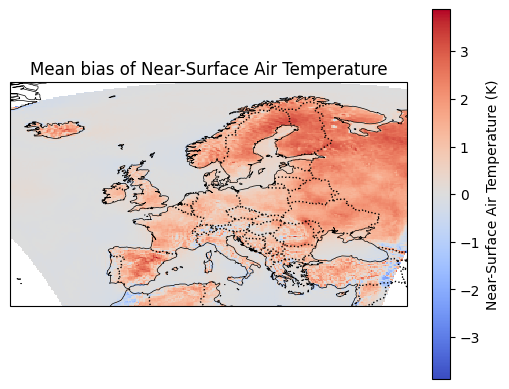

In [29]:
da = ds_obs['tas'].mean('time') - ds_mod['tas'].mean('time')

title = f"Mean bias of {da.long_name}"
cmap = "coolwarm"
cbar_label = f"{da.standard_name} bias ({da.units})"
da_obs = ds_obs['tas'].mean('time')

plot_spatial_bias(da)

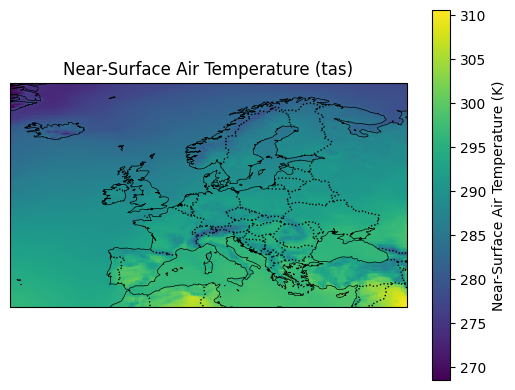

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from valenspy.diagnostic_visualizations import _add_features
da_obs = ds_obs['tas'].mean('time')
ax = plot_map(da_obs)

Now, both datasets are ready to be compared. 

## 3. Calculate the diagnostic and do plotting

First, we will only use the functions and not the diagnostic object


In [6]:
from valenspy.diagnostic_functions import *
from valenspy.diagnostic_visualizations import *

<Axes: title={'center': 'Mean bias of 2m temperature'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

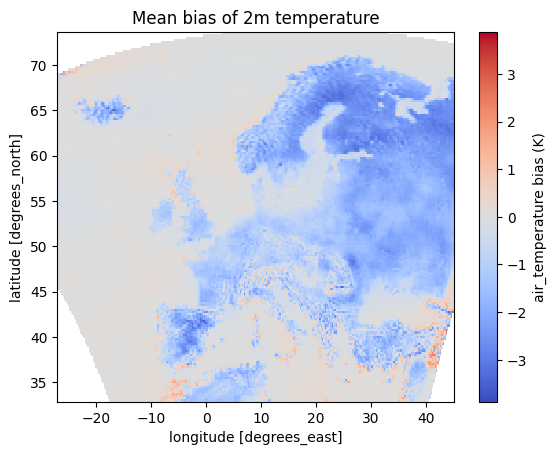

In [7]:
ds_spatialbias = spatial_bias(ds_mod, ds_obs)
plot_spatial_bias(ds_spatialbias[variable])




### Use the more elaborate plotting function available in Valenspy

- add in regions for mapping

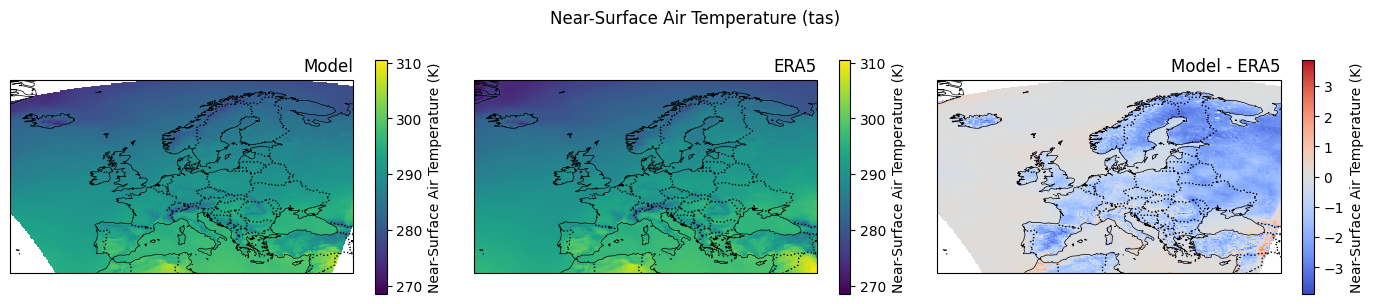

In [8]:
da_mod = ds_mod[variable].mean('time')
da_ref = ds_obs[variable].mean('time')
da_diff = ds_spatialbias[variable]
plot_maps_mod_ref_diff(da_mod,  da_ref,  da_diff)

### Now, we will do the same but using the object and its standard plotting function

In [9]:
from valenspy.diagnostic import SpatialBias
print(SpatialBias.description)

Spatial Bias (Model2Ref)
The spatial bias of the data compared to the reference.
 Diagnostic function: spatial_bias
 Calculate the mean spatial bias of the data compared to the reference. The time dimensions are averaged over if present.

    Parameters
    ----------
    ds : xr.Dataset or xr.DataArray
        The data to calculate the spatial bias of.
    ref : xr.Dataset or xr.DataArray
        The reference data to compare the data to.
    calc_relative : bool, optional
        If True, return the relative bias, if False return the absolute bias, by default False

    Returns
    -------
    xr.Dataset or xr.DataArray
        The spatial bias of the data compared to the reference.
    
 Visualization function: plot_spatial_bias
 Plot the spatial bias of the data compared to the reference.


<Axes: title={'center': 'Mean bias of 2m temperature'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

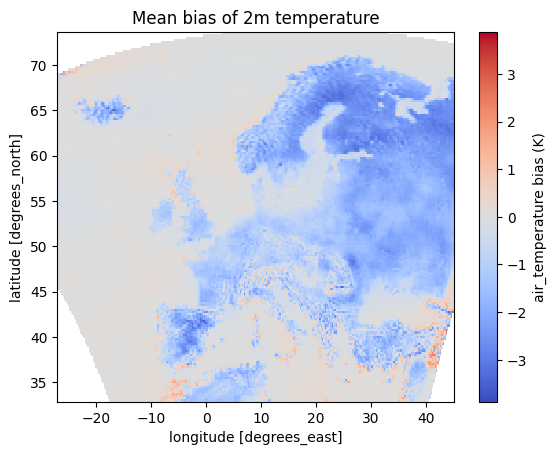

In [10]:
ds_bias = SpatialBias.apply(ds_mod, ds_obs).compute()
SpatialBias.plot(ds_bias[variable])